In [2]:
from astropy.modeling import models, fitting

from scipy.optimize import minimize

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import emcee
import corner
import random
import warnings

warnings.filterwarnings("ignore");

In [3]:
#read in data
lc_c = pd.read_csv('./lc_all.csv',delimiter=',');
VLBA = pd.read_csv('./VLBA.csv', delimiter=',');
lc_c =  lc_c.iloc[:, 1:-1];
x = np.linspace(lc_c.iloc[0,0], lc_c.iloc[-1,0], num=100);

#get initial model using astropy
p_init = models.BrokenPowerLaw1D(amplitude=2, x_break=19, alpha_1=0.7, alpha_2=-1); ## init power law
fit_p = fitting.LevMarLSQFitter(); ## which fitter to use
p = fit_p(p_init, lc_c.iloc[:,0], lc_c.iloc[:,2], maxiter=10000); ## fit the data

In [4]:
t = lc_c.iloc[:,0].to_numpy(dtype=np.float128);
y = lc_c.iloc[:,2].to_numpy(dtype=np.float128);
yerr = lc_c.iloc[:,3].to_numpy(dtype=np.float128);
x0 = np.linspace(t[0], t[-1], num=100);


In [5]:
def broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c):
    #Granot & sari 2002
    
    a = (t/t_b)**(-s*beta_1);
    b = (t/t_b)**(-s*beta_2);

    F_nu = F_c*(a+b)**(-1/s);
    
    return F_nu

def log_likelihood(theta, t, y, yerr):
    t_b, s, beta_1, beta_2, F_c = theta;
    #Granot & sari 2002

    model = broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c);
    
    return -0.5 * np.sum((y - model) ** 2 / yerr + np.log(yerr))

nll = lambda *args: -log_likelihood(*args);

initial = np.array([p.x_break.value, 1., p.alpha_1.value, p.alpha_2.value, p.amplitude.value]);
soln = minimize(nll, initial, args=(t, y, yerr),  method='Nelder-Mead', options={'disp':True, 'maxiter':10000});

t_bml, s_ml, beta_1ml, beta_2ml, F_cml = soln.x;


newy = broken_powerlaw(x0, t_bml, s_ml, beta_1ml, beta_2ml, F_cml);

Optimization terminated successfully.
         Current function value: -20.242226
         Iterations: 338
         Function evaluations: 563


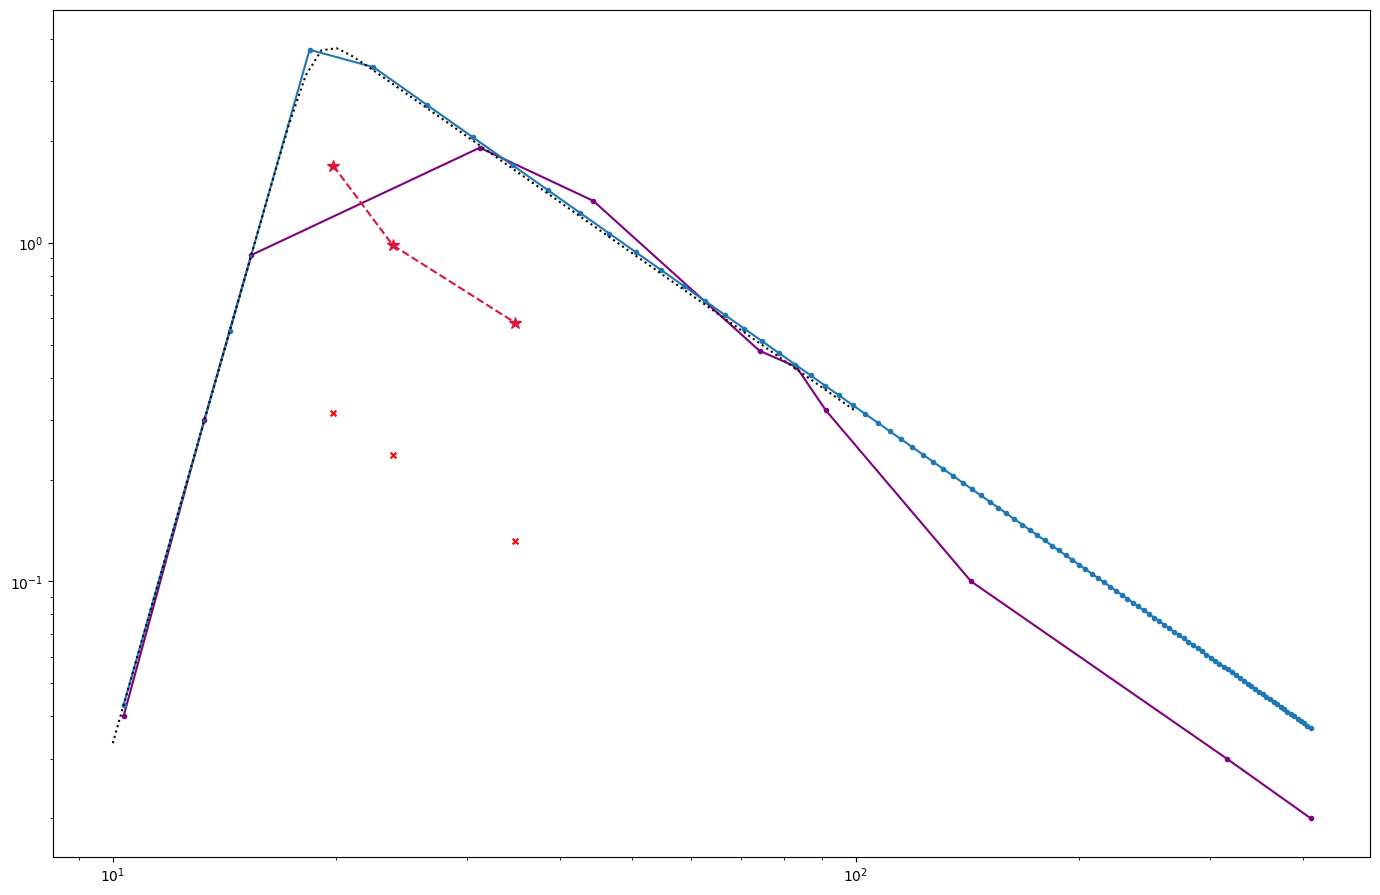

In [6]:
fig, ax = plt.subplots(figsize=(17,11), facecolor='white');

#generate some data
t_line = np.linspace(10,100,100);
# newy = broken_powerlaw(t_line, t_bml, beta_1ml, beta_2ml, F_cml);
# VLBA_plt = broken_powerlaw(VLBA['Day'], t_bml, beta_1ml, beta_2ml, F_cml);

newy = broken_powerlaw(t_line, t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
VLBA_plt = broken_powerlaw(VLBA['Day'], s_ml, t_bml, beta_1ml, beta_2ml, F_cml);

#actual plots
ax.plot(lc_c['Day'], lc_c['Flux'], color='purple', marker='.');
ax.plot(VLBA['Day'], VLBA['Flux'], linestyle='dashed', marker='*', markersize=9, color='crimson');
ax.scatter(VLBA['Day'], VLBA_plt, label='Guesstimate, using ML', color='red', s=17, marker='x');
ax.plot(x0, p(x0), marker='.', label='astropy broken powerlaw fit');
ax.plot(t_line, newy, ":k", label="ML broken powerlaw fit");
plt.loglog();

In [7]:

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta);
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr);


def log_prior(theta):
    t_b, s, beta_1, beta_2, F_c = theta;
    # print(theta);
    if 16 < t_b < 19  and 0.1 < s < 4 and -3 < beta_1 < 0 and 3 < beta_2 < 10 and 2 < F_c < 6:
        return 0.0
    return -np.inf

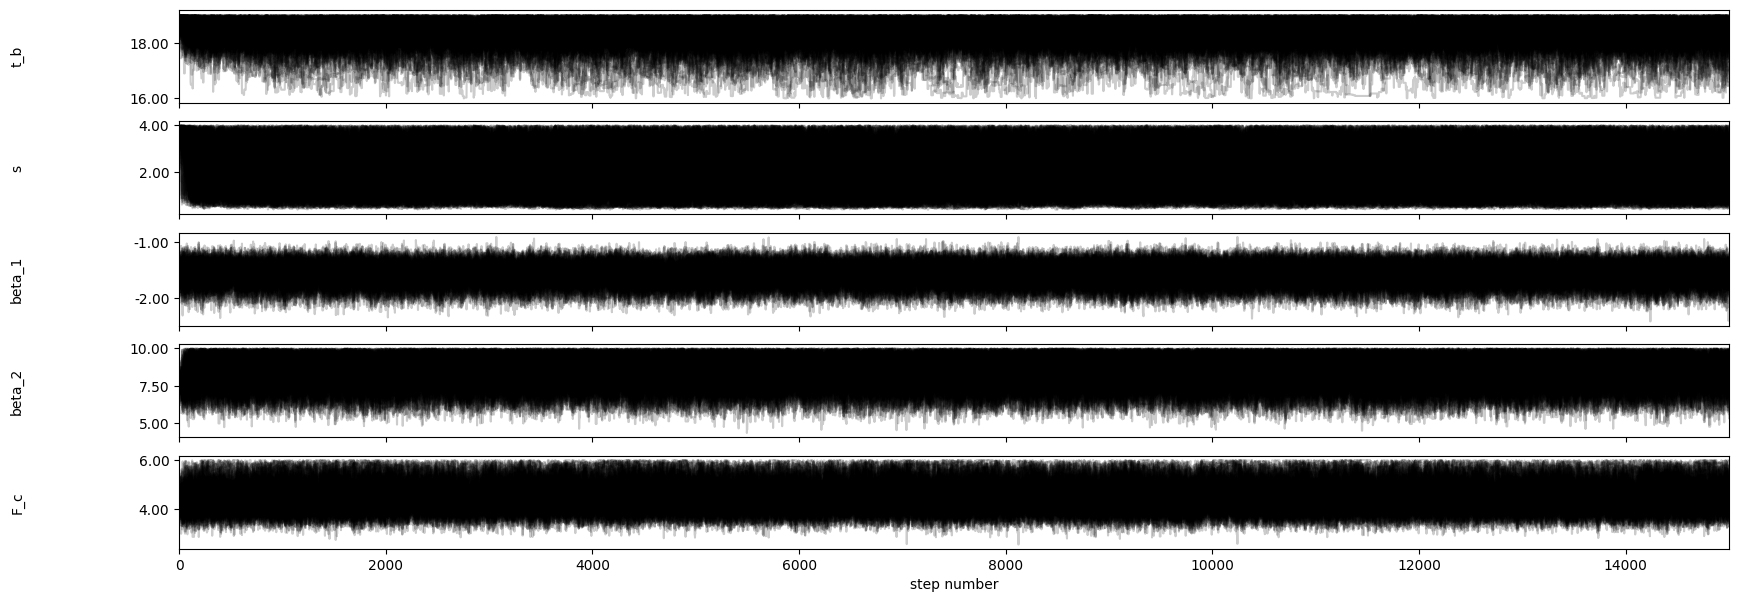

In [17]:
#the walker plots
plt.style.use('default');
fig, axes = plt.subplots(5, figsize=(20, 7), sharex=True);

samples = sampler.get_chain();

# labels = ["t_b", "beta_1", "beta_2", "F_c"];

labels = ["t_b", "s", "beta_1", "beta_2", "F_c"];
# for i in range(ndim):
#     ax = axes[i]
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
#     ax.plot(samples[:, :, i], "k", alpha=0.2)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

# plt.savefig(fname='./fits/walker_plot.png', format='png');

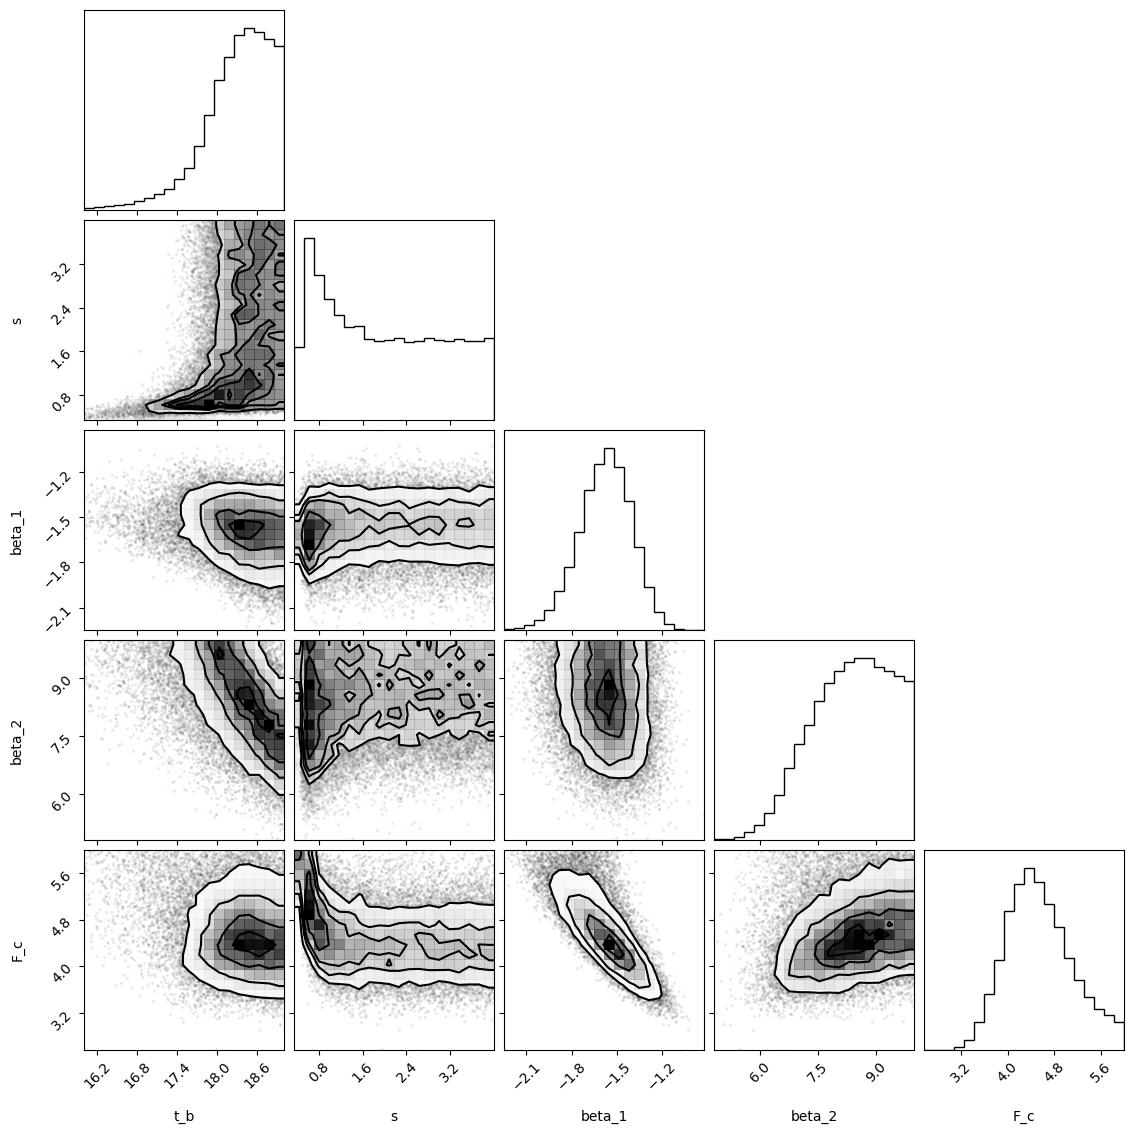

In [18]:
tau = sampler.get_autocorr_time();
discard_num = int(tau[0]*2.5);
thin_num = int(tau[0]*0.5);

flat_samples = sampler.get_chain(discard=discard_num, thin=thin_num, flat=True);
# flat_samples = sampler.get_chain(discard=664, thin=300, flat=True);
fig = corner.corner(flat_samples, labels=labels);

# plt.savefig(fname='./fits/corner_plots.png', format='png');

t_plot = np.linspace(8,500,10000);


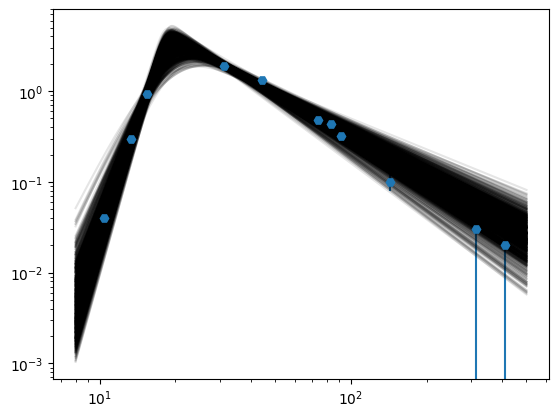

In [19]:
import random
t_plot = np.linspace(8,500,10000);

plt.figure(figsize=(17,11));
plt.errorbar(t,y,yerr,fmt = 'H');
for i in range(1000):
    theta = random.choice(flat_samples)
    t_b, s, beta_1, beta_2, F_c = theta
    model = broken_powerlaw(t_plot, t_b, s, beta_1, beta_2, F_c);
    plt.plot(t_plot,model,alpha = 0.1, color = 'black');


plt.loglog();

In [20]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>